In [1]:
import re
import requests
from bs4 import BeautifulSoup
import networkx as nx
import ipywidgets as widgets

G = nx.Graph()

In [2]:
#!jupyter nbextension enable --py widgetsnbextension --sys-prefix
#!jupyter serverextension enable voila --sys-prefix

In [3]:
page = requests.get("http://dtu-graph.lyxx.fr/data/class.html")
soup = BeautifulSoup(page.content, "html.parser")

for i in soup.findAll("tr"):
    #fetch departements
    if "colspan" in (str)(list(i.children)[1]):
        departement = list(i.children)[1].text.strip()
    #fetch class
    else:
        level = [v.strip() for v in list(i.children)[5].text.split(',')]
        classnumber = i.text.strip().split('\n')[0][:5]
        classname = i.text.strip().split('\n')[0][8:]
        langage, ects = [s.strip() for s in i.text.strip().split('\n')[1].split('|')[0:2]]
        ects = (float)(ects.split(' ')[0])

        #get schedule. First dimension : different option, second dimension : all the class to follow for this option
        res = ""
        for j in list(i.children)[3].findAll("span")[1:]:
            if j.text.strip() != "":
                res += j.text.strip()
        res = res.split("or")
        for j in range(len(res)):
            group = re.findall("([E][1-5]) ", res[j])
            res[j] = re.findall("(January|[E][1-5][AB])", res[j])
            for k in group:
                res[j].append(k + 'A')
                res[j].append(k + 'B')
        for i in range(len(res) - 1, -1, -1):
            if not res[i]:
                res.pop(i)              
        G.add_node(classnumber, name=classname, langage=langage, level=level, ects=ects, departement=departement, date=res)

In [4]:
page = requests.get("http://dtu-graph.lyxx.fr/data/ranking.html")
soup = BeautifulSoup(page.content, "html.parser")

#fetch class ratings
for i in soup.findChild("tbody").findAll("tr"):
    classnum = list(i.children)[0].text
    #some class might not exist anymore
    try:
        G.nodes[classnum]["avgGrade"] = list(i.children)[2].text
        G.nodes[classnum]["passed"] = list(i.children)[4].text
        G.nodes[classnum]["rating"] = list(i.children)[5].text
        G.nodes[classnum]["workload"] = list(i.children)[6].text
    except:pass
    

In [5]:
#this sections checks if 2 class can happen at the same time

def checkDate(a, b):
    for i in a:
        if i in b:
            return False
    return True
    
f = list(G.nodes())
def checkVariante(i, j):
    for iDate in G.nodes[f[i]]["date"]:
        for jDate in G.nodes[f[j]]["date"]:
            if checkDate(iDate, jDate):
                return True
    return False

In [6]:
#add edge to class that can happen at the same time
for i in range(len(G.nodes()) - 1):
    for j in range(i + 1, len(G.nodes())):
        if checkVariante(i, j):
            G.add_edge(f[i], f[j])

In [7]:
#Now preparing the filters for the UI.
langages = []
departements = []
levels = []

for i in G.nodes():
    if not G.nodes[i]["departement"] in departements:
        departements.append(G.nodes[i]["departement"])
    if not G.nodes[i]["langage"] in langages:
        langages.append(G.nodes[i]["langage"])
    for j in G.nodes[i]["level"]:
        if not j in levels:
            levels.append(j)

In [8]:
#this function will be called almost at every event on the UI
def updateSelect(c):
    select.options = showPossibleClass()
    chosen.options = showChosen()
    labelEcts.value = "Total : " + str(ectsCounter()) + " ECTS"

In [9]:
#langage selection
selectLangages = widgets.SelectMultiple(
    options=langages,
    description='Langage',
    layout= widgets.Layout(width='auto')
)

selectLangages.observe(updateSelect, 'value')

In [10]:
#departement selection
selectDepartement = widgets.SelectMultiple(
    options=departements,
    description='Departement',
    layout= widgets.Layout(width='auto')
)

selectDepartement.observe(updateSelect, 'value')

In [11]:
#level selection
selectLevel = widgets.SelectMultiple(
    options=levels,
    description='Level',
    layout= widgets.Layout(width='auto')
)

selectLevel.observe(updateSelect, 'value')

In [12]:
#we will show the total number of ECTS in this label
labelEcts = widgets.Label()

In [13]:
#compute what should be displayed where
chosenList = []

#is this node compatible with the ones already chosen ?
def canAdd(node):
    for i in chosenList:
        if node not in G[i]:
            return False
    return True

#check all nodes
def possibleClass():
    selectable = []
    for i in G.nodes():
        if canAdd(i):
            selectable.append(G.nodes[i])
    return selectable

#remove nodes that doesn't match the filters   
def classFiltered(selectable):
    selectableFiltered = []
    for i in selectable:
        if i["departement"] in selectDepartement.value and i["langage"] in selectLangages.value:
            for j in i["level"]:
                if j in selectLevel.value:
                    selectableFiltered.append(i)
                    break
    btnAdd.disabled = len(selectableFiltered) == 0
    if len(selectableFiltered) == 0:
        labelClassRanking.value = ""
    return selectableFiltered

#return the name of the class that can be picked
def showPossibleClass():
    display = []
    for i in classFiltered(possibleClass()):
        display.append(i["name"])
    return display

#return the selected class
def showChosen():
    display = []
    for i in chosenList:
        display.append(G.nodes[i]["name"])
    return display

#count the total number of ects. Format if integer
def ectsCounter():
    res = 0
    for i in chosenList:
        res += G.nodes[i]["ects"]
    return '%g'%(res)

In [14]:
#here we handle the buttons behaviour
def onAdd(c):
    for i in G.nodes():
        if G.nodes[i]["name"] == select.value:
            chosenList.append(i)
            break
    btnDel.disabled = False
    updateSelect(None)

def onRemove(c):
    for i in range(len(chosenList)):
        if G.nodes[chosenList[i]]["name"] == chosen.value:
            chosenList.pop(i)
            break
    if len(chosenList) == 0:
        btnDel.disabled = True
    updateSelect(None)

btnAdd = widgets.Button(
    description='Add',
    button_style='success',
    disabled=True
)

btnDel = widgets.Button(
    description='Remove',
    button_style='danger',
    disabled=True
)
btnDel.on_click(onRemove)
btnAdd.on_click(onAdd)


In [15]:
#add reviews about the currently selected pick
labelClassRanking = widgets.Label()

#initiate the list of the chosen class, and the possible picks
select = widgets.Select(
    options=showPossibleClass(),
    description='Possible picks',
    layout= widgets.Layout(width='50%')
)

chosen = widgets.Select(
    description='Your picks',
    layout= widgets.Layout(width='50%')
)

#handle the classranking display
def classRanking(c):
    for i in G.nodes():
        if G.nodes[i]["name"] == select.value:
            try:
                labelClassRanking.value = "Average grade : " + G.nodes[i]["avgGrade"] + " | " + \
                    "Passed : " + G.nodes[i]["passed"] + "% | " + "Rating : " + G.nodes[i]["rating"] + \
                    " | " + "Workload : " + G.nodes[i]["workload"] + " | "
            except:
                labelClassRanking.value = "No reviews yet for this class. | "
            labelClassRanking.value = labelClassRanking.value + '%g'%(G.nodes[i]["ects"]) + " ECTS"
            break
select.observe(classRanking, 'value')


In [16]:
#display the UI
widgets.VBox([
    widgets.HBox([chosen, btnDel]),
    labelEcts,
    widgets.Label("Filters"),
    widgets.HBox([selectDepartement, selectLangages, selectLevel]),
    widgets.HBox([select, btnAdd]),
    labelClassRanking   
])


In [17]:
#All the following cells goal is to gather information about the graph for the website
G.number_of_nodes(), G.number_of_edges()

(645, 178230)

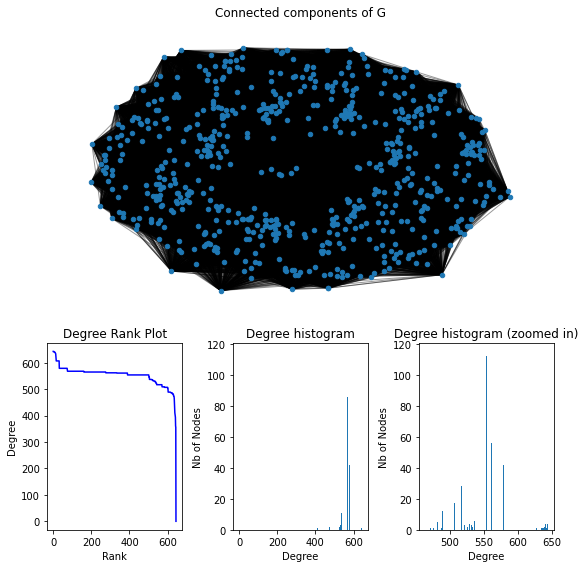

In [18]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

degree_sequence = sorted([d for n, d in G.degree()], reverse=True)
L=[]
for i in range(len(degree_sequence)):
    if degree_sequence[i]>450:
        L.append(degree_sequence[i])
dmax = max(degree_sequence)

fig = plt.figure("Degree of a random graph", figsize=(8, 8))
# Create a gridspec for adding subplots of different sizes
axgrid = fig.add_gridspec(5, 6)

# Drawing the graph

ax0 = fig.add_subplot(axgrid[0:3, :])
Gcc = G.subgraph(sorted(nx.connected_components(G), key=len, reverse=True)[0])
pos = nx.spring_layout(Gcc, seed=10396953)
nx.draw_networkx_nodes(Gcc, pos, ax=ax0, node_size=20)
nx.draw_networkx_edges(Gcc, pos, ax=ax0, alpha=0.4)
ax0.set_title("Connected components of G")
ax0.set_axis_off()

# Sorted degree of the nodes

ax1 = fig.add_subplot(axgrid[3:, :2])
ax1.plot(degree_sequence, "b-")
ax1.set_title("Degree Rank Plot")
ax1.set_ylabel("Degree")
ax1.set_xlabel("Rank")

# Degree distribution

ax2 = fig.add_subplot(axgrid[3:, 2:4])
ax2.bar(*np.unique(degree_sequence, return_counts=True))
ax2.set_title("Degree histogram")
ax2.set_xlabel("Degree")
ax2.set_ylabel("Nb of Nodes")

# Degree distribution (nodes which degree is more than 450)

ax2 = fig.add_subplot(axgrid[3:, 4:6])
ax2.bar(*np.unique(L, return_counts=True))
ax2.set_title("Degree histogram (zoomed in)")
ax2.set_xlabel("Degree")
ax2.set_ylabel("Nb of Nodes")

fig.tight_layout()
plt.show()

In [19]:
max(degree_sequence,key=degree_sequence.count)

565